介绍基础的机器学习概念与实例，作为入门

## 用户信用风险评估系统

某金融公司现有客户数据集，包含 1000 条用户数据，字段如下：

输入特征（原始）：
- 年龄（age）
- 工作年限（work_year）
- 教育程度（education：0=高中及以下，1=本科，2=硕士及以上）
- 负债比例（debt_ratio）
- 信用卡数量（credit_card_num）

中间目标：月收入（monthly_income，连续值，需用线性回归预测）；

中间标签：是否逾期（is_overdue，二分类，需用逻辑回归预测）；

最终标签：信用等级（credit_rating，多分类：A/B/C/D，需用决策树预测）

公司需要构建信用风险评估系统, 流程如下：

- 先用线性回归预测用户的 "月收入水平"（连续值）
- 再用逻辑回归基于月收入及其他特征预测用户 "是否有逾期记录"（二分类：0 = 无逾期，1 = 有逾期）；
- 最后用决策树基于逾期记录、收入预测结果及原始特征，预测用户 "信用等级"（多分类：A/B/C/D）；

验证三个模型的串联效果，并分析决策树的特征重要性

线性回归：通过MSE评估月收入预测精度（值越小越好），体现连续值预测能力；

逻辑回归：通过准确率和分类报告（精确率、召回率）评估逾期预测效果，需关注对 "有逾期"（少数类）的识别能力；

决策树：通过多分类准确率和特征重要性，分析哪些因素（如预测的收入、是否逾期）对信用等级影响最大；

串联逻辑：前一个模型的输出作为后一个模型的输入，模拟真实业务中 "多步骤评估" 的场景（如先估收入，再评逾期风险，最后定信用等级）

实现步骤
1. 数据预处理（缺失值填充、特征标准化）；
2. 训练线性回归模型预测月收入；
3. 训练逻辑回归模型预测逾期记录（输入含线性回归的预测结果）；
4. 训练决策树模型预测信用等级（输入含前两个模型的预测结果）；
5. 模型评估与结果分析

In [2]:
import sklearn
print(sklearn.__version__)

1.7.0


In [49]:
import pandas as pd  # 数据处理
import numpy as np  # 数值计算
from sklearn.model_selection import train_test_split  # 划分训练集和测试集
from sklearn.preprocessing import StandardScaler  # 特征标准化
from sklearn.impute import SimpleImputer  # 缺失值填充

# 导入模型：线性回归、逻辑回归、决策树分类器
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# 导入评估指标：均方误差 MSE、准确率 accuracy_score、分类报告 classification_report
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.tree import plot_tree  # 可视化决策树
import matplotlib.pyplot as plt  # 绘图

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

### 生成模拟数据

In [31]:
# 设置随机种子，保证结果可复现
np.random.seed(42)
# 生成1000条样本
n = 1000
# 构建基础特征字典
data = {
    "age": np.random.randint(18, 65, n),  # 年龄：18-64岁的随机整数
    "work_year": np.random.randint(0, 40, n),  # 工作年限：0-39年的随机整数
    # 教育程度：0=高中及以下，1=本科，2=研究生；按比例[30%,50%,20%]生成
    "education": np.random.choice([0, 1, 2], n, p=[0.3, 0.5, 0.2]),
    "debt_ratio": np.random.uniform(0.1, 0.8, n),  # 债务比率：0.1-0.8的随机浮点数
    "credit_card_num": np.random.randint(1, 10, n)  # 信用卡数量：1-9张的随机整数
}

# 生成月收入（受多个因素影响的模拟数据）
# 基础公式：3000起薪 + 工作年限*800 + 教育程度*2000 + 年龄*50 + 随机波动
data["monthly_income"] = 3000 + data["work_year"]*800 + data["education"]*2000 + data["age"]*50 + np.random.normal(0, 1000, n)

# 生成是否逾期的标签（0=未逾期，1=逾期）
# 第一步：用sigmoid函数计算逾期概率（将线性组合压缩到0-1之间）
# 线性组合公式：-0.0005*月收入（收入越高，逾期概率越低） + 3*债务比率（债务越高，逾期概率越高） -0.01*年龄（年龄越大，逾期概率越低）
overdue_prob = 1 / (1 + np.exp(-( -0.0005*data["monthly_income"] + 3*data["debt_ratio"] - 0.01*data["age"] )))
# 第二步：根据概率用伯努利分布生成0/1标签（1表示逾期，概率由overdue_prob决定）
data["is_overdue"] = np.random.binomial(1, overdue_prob)

# 生成信用等级（A/B/C/D，模拟实际信用评分场景）
# 第一步：计算评分（受收入、逾期状态、教育程度、债务比率影响）
rating_score = (data["monthly_income"]/100) - (data["is_overdue"]*500) + (data["education"]*200) - (data["debt_ratio"]*1000)
# 第二步：根据评分区间划分等级（A最高，D最低）
data["credit_rating"] = pd.cut(rating_score, bins=[-np.inf, 30, 60, 90, np.inf], labels=["D", "C", "B", "A"])

# 将字典转换为DataFrame（表格形式）
df = pd.DataFrame(data)

数据预处理（缺失值填充、特征标准化）

**训练集进行训练并转换，测试集使用训练集训练的模型进行转换**

In [33]:
# 划分测试数据集

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# 缺失值填充
# 用中位数填充缺失值（中位数对异常值不敏感，适合收入这类可能有极端值的数据）
imputer = SimpleImputer(strategy="median")  # 创建填充器，策略为"中位数"
train_df["monthly_income"] = imputer.fit_transform(train_df[["monthly_income"]])
test_df["monthly_income"] = imputer.transform(test_df[["monthly_income"]])

# 特征标准化
# 需要标准化的 「数值特征列表」
num_features = ["age", "work_year", "debt_ratio", "credit_card_num", "monthly_income"]
scalar = StandardScaler()
train_df[num_features] = scalar.fit_transform(train_df[num_features])
test_df[num_features] =scalar.transform(test_df[num_features])

线性回归：预测月收入

In [34]:
# 选择用于预测的特征
lr_features = ["age", "work_year", "education", "credit_card_num"]

x_lr_train = train_df[lr_features]
y_lr_train = train_df['monthly_income']
x_lr_test = test_df[lr_features]
y_lr_test = test_df['monthly_income']

# 初始化并训练线性回归模型
lr = LinearRegression()
lr.fit(x_lr_train, y_lr_train)

# 用训练好的模型在测试集上预测
y_lr_predict = lr.predict(x_lr_test)

# 评估预测效果：计算均方误差（MSE），值越小说明预测越准确
print(f"线性回归月收入预测 MSE：{mean_squared_error(y_lr_test, y_lr_predict):.4f}")

线性回归月收入预测 MSE：0.0102


逻辑回归：预测是否逾期

In [35]:
print(test_df.shape)
print(y_lr_predict.shape)


(200, 8)
(200,)


In [ ]:
# 选择用于预测逾期的特征：债务比率、年龄
logic_feature = ["debt_ratio", "age"]

# 将线性回归预测的月收入作为新特征加入（用模型预测的收入代替原始收入，模拟实际中收入可能难以准确获取的场景）
train_df["pred_income"] = lr.predict(train_df[lr_features])  # 训练集用模型预测收入
test_df["pred_income"] = y_lr_predict  # 测试集直接用之前的预测结果

x_logic_train = train_df[["pred_income"] + logic_feature]
y_logic_train = train_df['is_overdue']
x_logic_test = test_df[["pred_income"] + logic_feature]
y_logic_test = test_df['is_overdue']

# class_weight="balanced"：自动调整类别权重，解决可能的样本不平衡问题（逾期样本可能较少）
logic_model = LogisticRegression(class_weight="balanced")
logic_model.fit(x_logic_train, y_logic_train)
y_logic_predict = logic_model.predict(x_logic_test)

# 评估
print(f"逻辑回归逾期预测准确率：{accuracy_score(y_logic_test, y_logic_predict):.4f}")
# 生成报告
print(classification_report(y_logic_test, y_logic_predict))

逻辑回归逾期预测准确率：0.9050
              precision    recall  f1-score   support

           0       1.00      0.90      0.95       198
           1       0.10      1.00      0.17         2

    accuracy                           0.91       200
   macro avg       0.55      0.95      0.56       200
weighted avg       0.99      0.91      0.94       200



决策树：预测信用等级

In [45]:
# 选择用于预测信用等级的特征：教育程度、信用卡数量
tree_features = ["education", "credit_card_num"]

# 将逻辑回归预测的逾期结果作为新特征加入
train_df['pred_overdue'] = logic_model.predict(x_logic_train)
test_df['pred_overdue'] = y_logic_predict

# 构建决策树的训练数据（组合原始特征和前两个模型的预测结果）
x_tree_train = train_df[["pred_overdue"] + tree_features]
y_tree_train = train_df['credit_rating']
x_tree_test = test_df[["pred_overdue"] + tree_features]
y_tree_test = test_df['credit_rating']

# max_depth=5：限制树深度，避免过拟合（决策树容易过度复杂而记住训练数据）
tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_model.fit(x_tree_train, y_tree_train)
y_tree_predict = tree_model.predict(x_tree_test)

print(f"决策树信用等级预测准确率：{accuracy_score(y_tree_test, y_tree_predict):.4f}")
print("决策树分类报告：")
print(classification_report(y_tree_test, y_tree_predict, zero_division=1))


决策树信用等级预测准确率：0.6750
决策树分类报告：
              precision    recall  f1-score   support

           A       0.64      0.50      0.56        58
           B       1.00      0.00      0.00        11
           C       1.00      0.00      0.00        15
           D       0.68      0.91      0.78       116

    accuracy                           0.68       200
   macro avg       0.83      0.35      0.34       200
weighted avg       0.71      0.68      0.62       200



结果分析, 输出决策树的特征重要性


决策树特征重要性：
pred_overdue：0.2309
education：0.6815
credit_card_num：0.0876


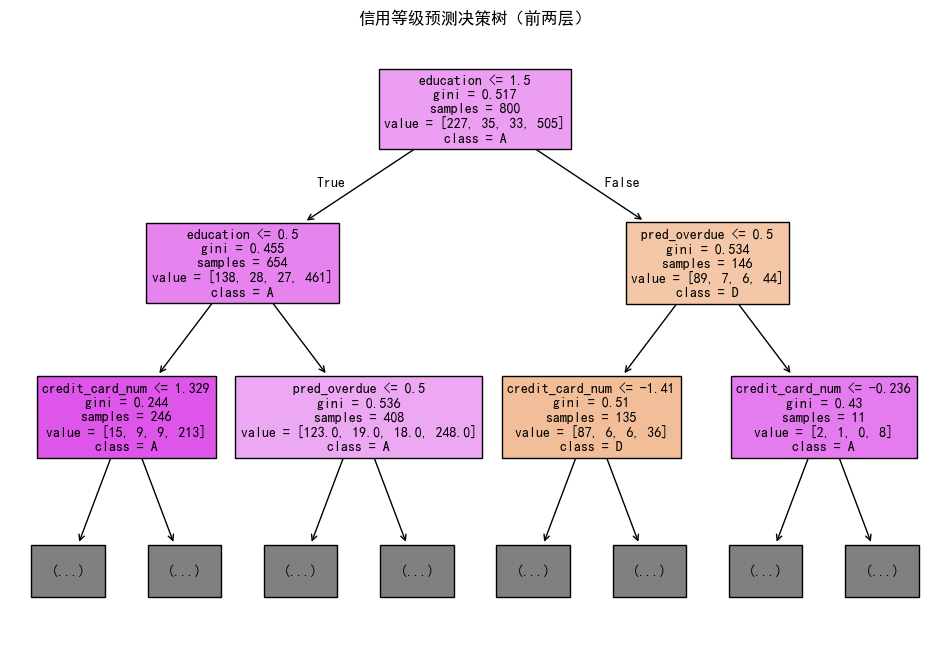

In [50]:
print("\n决策树特征重要性：")
for name, imp in zip(x_tree_train.columns, tree_model.feature_importances_):
    print(f"{name}：{imp:.4f}")  # 数值越大，该特征对信用等级预测的影响越大

# 可视化决策树（仅显示前两层，避免图形过于复杂）
plt.figure(figsize=(12, 8))  # 设置画布大小
# 绘制决策树：特征名称、类别名称、填充颜色、最大深度2层、字体大小10
plot_tree(tree_model, feature_names=x_tree_train.columns, class_names=["D", "C", "B", "A"], 
          filled=True, max_depth=2, fontsize=10)
plt.title("信用等级预测决策树（前两层）")  # 添加标题
plt.show()  # 显示图形

In [3]:
import jieba
import jieba.posseg as pseg  # 导入词性标注模块

# 使用pseg.cut进行词性标注
def pos_tagging(text):
    """
    进行词性标注分词
    
    参数:
    text: 待分词文本
    
    返回:
    包含词语和词性的元组列表
    """
    words = pseg.cut(text)
    return [(word, flag) for word, flag in words]


text = "小明在图书馆看书"
result = pos_tagging(text)
print(result)


[('小明', 'nr'), ('在', 'p'), ('图书馆', 'n'), ('看书', 'v')]
